# Expected SARSA 

We will be using **TD control method of Expected SARSA** on Cliff World environment as given below. Expected SARSA takes the average over $Q(S',A')$ weighed by the policy. Here we will using the same policy to explore and same policy to take expectation and hence it is a on-policy SARSA. However, depending on the need, we could have agent trying to learn a ε-greedy policy but use a more exploratory (i.e. with higher ε value) policy as its behavior policy to generate samples.

![GridWorld](./images/cliffworld.png "Cliff World")


### Expected SARA  Update equation

Expected SARA Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. And we update the Q value by taking expectation over the policy. The Update equation is given below:

$$ Q(S,A) ← Q(S,A) + α * [ R + γ * \sum_{A'} \pi(A'|S')* Q(S’,A’) – Q(S,A)] $$



In [1]:
# Initial imports and environment setup
import sys
import gymnasium as gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Expected SARSA Learning agent class
from collections import defaultdict


class ExpectedSARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Expected SARSA Update
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            actions = self.get_possible_actions(next_state)
            next_q = 0
            for next_action in actions:
                if next_action == best_next_action:
                    next_q += (1-self.epsilon+self.epsilon/len(actions)) * \
                               self.get_Q(next_state, next_action)
                else:
                    next_q += (self.epsilon/len(actions)) * \
                               self.get_Q(next_state, next_action)

            td_error = reward + self.gamma * next_q - self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period. YOu can set the flag to False
                # and see the impact it has on the episode rewards
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [4]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [5]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

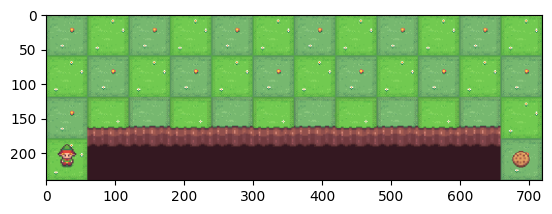

In [13]:
# create cliff world environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [14]:
# create an Expected SARSA agent
agent = ExpectedSARSAAgent(alpha=1.0, epsilon=0.2, gamma=0.99,
                           get_possible_actions=lambda s : range(env.nA))

# train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 10000)

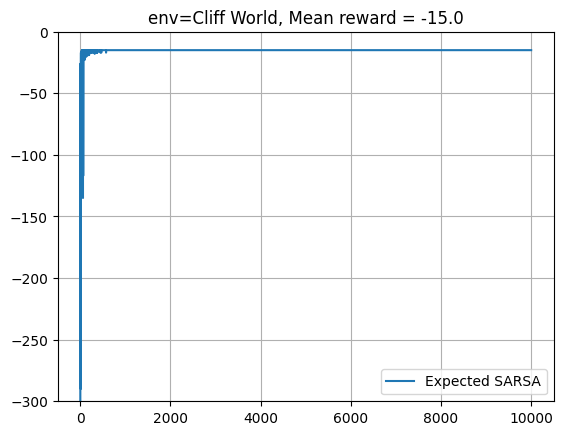

In [15]:
# Plot per episode reward graph
plot_rewards("Cliff World", rewards, 'Expected SARSA')

In [16]:
# print CLiff Wolrd policy
print_policy(env, agent)

 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Expected SARSA for "Taxi" environment 

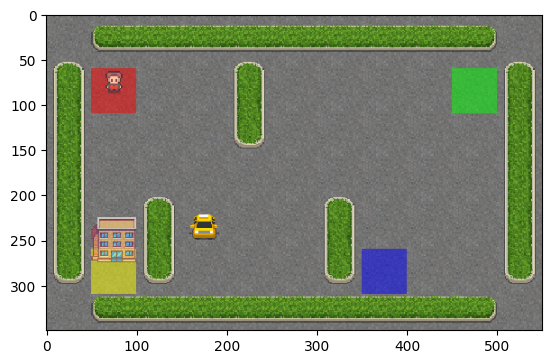

In [10]:
# create taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

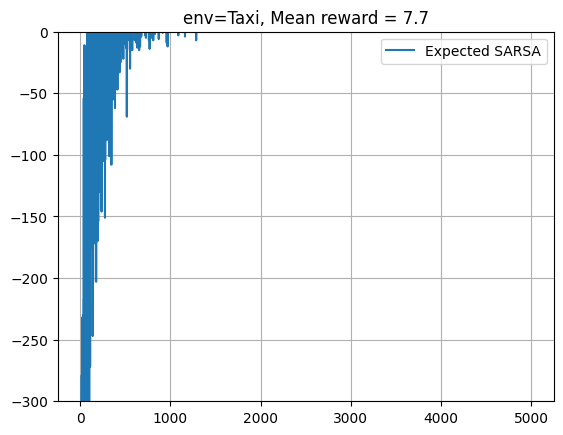

In [11]:
# create am Expected SARSA agent
agent = ExpectedSARSAAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                           get_possible_actions=lambda s : range(env.action_space.n))

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

#plot reward graph
plot_rewards("Taxi", rewards, 'Expected SARSA')

### Conclusion

We see that Expected SARSA Agent learns the optimal policy by about 1000 episodes of training in case of CLiff World. If you see the update equation, you will notice that Q(S',A') is averaged over. So even with exploration, it is able to lean a policy better than normal SARA. The policy learnt by agent here is to go through the middle row which is kind of a combination of both SARSA and Q-learning. 